This should be the multi-location solar irradiance prediction model based on weather data from 5 weather stations around Edmonton. This colab process the multi-location data by combining them into a big single table with each column dedicated to a single location's weather data. This is the easiest method but relies on the fact that position of each station never changes.

# **Setup**

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import math as math
import glob as glob
import sklearn as sklearn



mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# **Data Processing**

## Loading and Importing Data

###Read file in

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/LydiaSS/Solar_Irradiance_Forecast_RNN/main/ACISHourlyData_GoodOrder.csv", encoding='utf-8', index_col=None, header=0, thousands=',')
print(df.columns)

df['Incoming Solar Rad. (W/m2)'] = pd.to_numeric(df['Incoming Solar Rad. (W/m2)'], downcast="float")

def file_cleanup(df):
    # Some Cleaning
    df.drop_duplicates()

    # Get rid of columns that don't contain any useful data (like comment cols)
    preliminary_column_mask = [
          'Station Name',
          'Date (Local Standard Time)', 
          'Air Temp. Inst. (C)',
          'Air Temp. Min. (C)',
          'Air Temp. Max. (C)',
          'Air Temp. Avg. (C)',
          'Humidity Inst. (%)',
          'Humidity Avg. (%)',
          'Incoming Solar Rad. (W/m2)',
          'Precip. Accumulated (mm)',
          'Precip. (mm)',
          'Wind Speed 10 m Syno. (km/h)',
          'Wind Dir. 10 m Syno. ()',
          'Wind Speed 10 m Avg. (km/h)',
          'Wind Dir. 10 m Avg. ()',]

    df = df[df.columns.intersection(preliminary_column_mask)]

    # Rename
    df = df.rename(columns={'Wind Dir. 10 m Syno. ()': 'Wind Dir. 10 m Syno. (deg)', 
                      'Wind Dir. 10 m Avg. ()': 'Wind Dir. 10 m Avg. (deg)'})

    df.head()

    return df

df = file_cleanup(df)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4,7,10,13,16,19,31,37) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Index(['Station Name', 'Date (Local Standard Time)', 'Air Temp. Inst. (C)',
       'Air Temp. Inst. Source Flag', 'Air Temp. Inst. Comment',
       'Air Temp. Min. (C)', 'Air Temp. Min. Source Flag',
       'Air Temp. Min. Comment', 'Air Temp. Max. (C)',
       'Air Temp. Max. Source Flag', 'Air Temp. Max. Comment',
       'Air Temp. Avg. (C)', 'Air Temp. Avg. Source Flag',
       'Air Temp. Avg. Comment', 'Humidity Inst. (%)',
       'Humidity Inst. Source Flag', 'Humidity Inst. Comment',
       'Humidity Avg. (%)', 'Humidity Avg. Source Flag',
       'Humidity Avg. Comment', 'Incoming Solar Rad. (W/m2)',
       'Incoming Solar Rad. Source Flag', 'Incoming Solar Rad. Comment',
       'Precip. Accumulated (mm)', 'Precip. Accumulated Source Flag',
       'Precip. Accumulated Comment', 'Precip. (mm)', 'Precip. Source Flag',
       'Precip. Comment', 'Wind Speed 10 m Syno. (km/h)',
       'Wind Speed 10 m Syno. Source Flag', 'Wind Speed 10 m Syno. Comment',
       'Wind Dir. 10 m Syno. ()

In [4]:
# Separate the data by station location
#grouped = df.groupby(df['Station Name'])

df_SOUTH_CAMPUS = df.loc[df['Station Name'].isin(["Edmonton South Campus UA"])]
df_ST_ALBERT = df.loc[df['Station Name'].isin(["St. Albert Research"])]

df_OLIVER = df.loc[df['Station Name'].isin(["Oliver AGDM"])]
df_LEGAL = df.loc[df['Station Name'].isin(["Legal AGCM"])]
df_ST_FRANCIS = df.loc[df['Station Name'].isin(["St. Francis AGCM"])]

station_dfs = [df_SOUTH_CAMPUS, df_ST_ALBERT, df_OLIVER, df_LEGAL, df_ST_FRANCIS]
# Include weather station geographical location data, note the Lat and Long also have a direction associated but since these
#   stations are close to each other the directions are the same and  not considered in this application
# Lat and Long data processing: data are taken from the gov of Canada website and converted to decimal using https://www.fcc.gov/media/radio/dms-decimal
station_locations = [
    {
      "Name": "Edmonton South Campus UA",
      "Latitude": 53.490014,
      "Longitude": 113.537778,
      "Elevation (m)": 670.00,
      "df": df_SOUTH_CAMPUS,
    },
    {
      "Name": "St. Albert Research",
      "Latitude": 53.691944,
      "Longitude": 113.619722,
      "Elevation (m)": 687.00,
      "df": df_ST_ALBERT,
    },
    {
      "Name": "Oliver AGDM",
      "Latitude": 53.65,
      "Longitude": 113.35,
      "Elevation (m)": 665.00,
      "df": df_OLIVER,
    },
    {
      "Name": "Legal AGCM",
      "Latitude": 54.003056,
      "Longitude": 113.474445,
      "Elevation (m)": 680.00,
      "df": df_LEGAL,
    },
    {
      "Name": "St. Francis AGCM",
      "Latitude": 53.294731,
      "Longitude": 114.320011,
      "Elevation (m)": 809.00,
      "df": df_ST_FRANCIS,
    },    
]

In [5]:
df_LEGAL["date"] = pd.to_datetime(df['Date (Local Standard Time)'])
# I realized that one location doesn't have solar irradiance data before the following date
res = df_LEGAL[~(df_LEGAL['date'] < '2018-07-01')]

# Let's cut all dataframe to ^ date then
for i in range(5):
  station_dfs[i]["date"] = pd.to_datetime(df['Date (Local Standard Time)'])
  station_dfs[i] = station_dfs[i][~(station_dfs[i]['date'] < '2018-07-01')]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


###Remove Zero Solar Irradiance Data

This needs to be optimized but for now let's just do a simple cut-out for all times after 10pm and before 6am. 

In [6]:
# Take out timestamps after 10pm and before 6am for all 
for i in range(5):
  # Get all wanted column names from df
  station_dfs[i] = station_dfs[i].set_index('date')
  station_dfs[i] = station_dfs[i].between_time("5:00", "22:00")

### Basic Processing

In [7]:
# Now we get rid of columns that are not passed to the NN
ws_col = 'Wind Speed 10 m Avg. (km/h)'
ws_max_col = 'Wind Speed 10 m Syno. (km/h)'
wd_col = 'Wind Dir. 10 m Avg. (deg)'
date_col = 'Date (Local Standard Time)'
temp_col = 'Air Temp. Avg. (C)'
solar_irr_col = 'Incoming Solar Rad. (W/m2)'
humidity_col = 'Humidity Avg. (%)'

# Create a list to hold training only column
# Hardware support only solar irradiance and humidty columns
train_col_mask = [temp_col, solar_irr_col, humidity_col]

# Save timestamp into its own df first
datetime = pd.to_datetime(station_dfs[0].reset_index().pop('Date (Local Standard Time)'), format='%Y-%m-%d %H:%M')
timestamp_s = datetime.map(pd.Timestamp.timestamp)

# Reset index so index of df starts at 0
station_dfs[0] = station_dfs[0].reset_index()

for i in range(5):
  # Get all wanted column names from df
  station_dfs[i] = station_dfs[i][station_dfs[i].columns.intersection(train_col_mask)]
  # Equal all the index
  station_dfs[i].index = station_dfs[0].index

# Combine all columns of the five stations
df_all = pd.concat(station_dfs, axis = 1)

## Process Data

Another important criteria to consider in data processing is how will the data best make sense to the algorithm? 

Certain parameter such as temperature can be kept as it is, but others such as year, date, and time do not make much sense if kept as '2009' or 'Jan 14' or '12pm' to the algorithm. Similar with the angle in the wind direction, a human can intepret the degree value as a point on the compass but to an algorithm, 0 will be 0 and 360 will be 360. 

Processing of these data are presented in the following subsections.

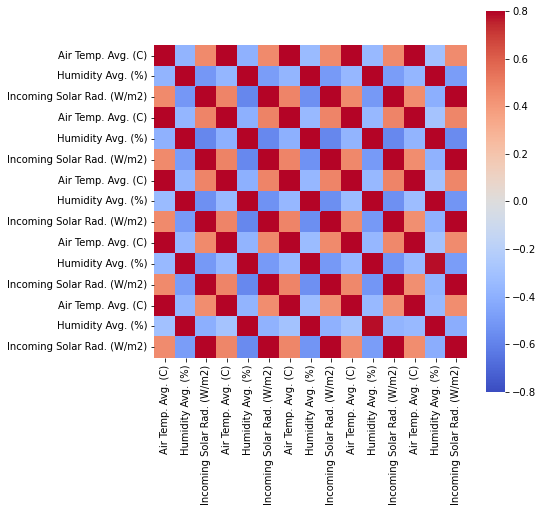

In [8]:
# Correlation
corrmat = df_all#.drop(['TimeOfDay(h)', 'TimeOfDay(m)', 'TimeOfDay(s)', 'UNIXTime', 'MonthOfYear', 'WeekOfYear'], inplace=False, axis=1)
corrmat = corrmat.corr()
f, ax = plt.subplots(figsize=(7,7))
sns.heatmap(corrmat, vmin=-.8, vmax=.8, square=True, cmap = 'coolwarm')
plt.show()

Now we make sure to remove the NA in each field and double check. Notice how the length is reduced and likely some timestamps are missing. These are ignored for now, but future improvement may include replacing the missing data with interpolation.


### Time Data

The most important thing about time is that weather data usually exhibit a periodicity related to time. Hence it is common to use cosine/sine on time.


Because we remove a large chunk of night times the graph will have a jump at some parts.

Text(0.5, 1.0, 'Time of year signal')

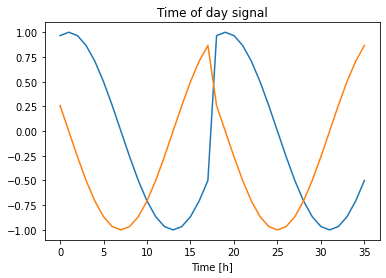

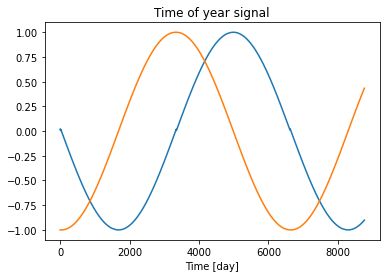

In [9]:
# For periodicity within a day, we find the total number of seconds in a day
day = 24*60*60
# For periodicity within a year, we find the total number of seconds in a year
year = (365.2425)*day

df_all['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
# Apparently cos has worse correlation with the solar irradiance lol
df_all['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df_all['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df_all['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.figure(0)
plt.plot(np.array(df_all['Day sin'])[:18*2])
plt.plot(np.array(df_all['Day cos'])[:18*2])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

plt.figure(1)
plt.plot(np.array(df_all['Year sin'])[:math.floor(year/60**2)])
plt.plot(np.array(df_all['Year cos'])[:math.floor(year/60**2)])
plt.xlabel('Time [day]')
plt.title('Time of year signal')

In [10]:
df_all = df_all.dropna()
df_all.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
Air Temp. Avg. (C),18198.0,3.946192,12.493704,-36.6,-4.400000,4.100000,14.200000,34.300000
Humidity Avg. (%),18198.0,66.508726,20.296023,10.6,51.300000,67.900000,82.300000,100.000000
Incoming Solar Rad. (W/m2),18198.0,165.150055,209.031937,0.0,0.000000,71.300003,267.100006,905.000000
Air Temp. Avg. (C),18198.0,2.663815,12.853031,-42.2,-5.800000,2.800000,13.200000,33.000000
Humidity Avg. (%),18198.0,71.540856,18.314455,11.9,59.700000,74.600000,86.300000,100.000000
Incoming Solar Rad. (W/m2),18198.0,165.437134,209.294876,0.0,0.100000,72.549999,264.399994,908.000000
Air Temp. Avg. (C),18198.0,2.979893,12.952719,-43.0,-5.300000,3.300000,13.500000,34.000000
Humidity Avg. (%),18198.0,71.447692,20.336601,12.2,56.600000,73.800000,88.600000,100.000000
Incoming Solar Rad. (W/m2),18198.0,172.119507,218.041000,0.0,0.100000,72.500000,281.075005,920.000000
Air Temp. Avg. (C),18198.0,2.520832,12.854626,-40.7,-5.900000,2.700000,13.100000,31.800000


##Data Visualization

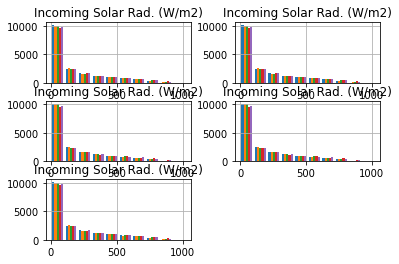

In [11]:
hist = df_all[solar_irr_col].hist(bins=10)
# Ok data looks okay

### Split the Data

A (70%, 20%, 10%) split is used for the training, validation, and test sets. The data is not being randomly shuffled before splitting due to the nature of time series prediction which requires chopping the data into windows of consecutive samples.

In [12]:
column_indices = {name: i for i, name in enumerate(df_all.columns)}
# Split the data
n = len(df_all)
train_df = df_all[0:int(n*0.7)]
val_df = df_all[int(n*0.7):int(n*0.9)]
test_df = df_all[int(n*0.9):]
# Count how many columns
num_features = df_all.shape[1]

In [13]:
print(train_df.shape)
train_df.columns

(12738, 19)


Index(['Air Temp. Avg. (C)', 'Humidity Avg. (%)', 'Incoming Solar Rad. (W/m2)',
       'Air Temp. Avg. (C)', 'Humidity Avg. (%)', 'Incoming Solar Rad. (W/m2)',
       'Air Temp. Avg. (C)', 'Humidity Avg. (%)', 'Incoming Solar Rad. (W/m2)',
       'Air Temp. Avg. (C)', 'Humidity Avg. (%)', 'Incoming Solar Rad. (W/m2)',
       'Air Temp. Avg. (C)', 'Humidity Avg. (%)', 'Incoming Solar Rad. (W/m2)',
       'Day sin', 'Day cos', 'Year sin', 'Year cos'],
      dtype='object')

### Normalize the data

We can use std normalization here but all solar irradiantion columns should have the same mean and standard deviation so we combine all columns to calculate.

In [14]:
# Trying a new way of standardizing solar irradiance because the old one is hard to reduce MAE and MAPE at the same time
max = train_df.max()[1]
train_solar_irr_normalized = train_df[solar_irr_col]/max
test_solar_irr_normalized = test_df[solar_irr_col]/max
val_solar_irr_normalized = val_df[solar_irr_col]/max

In [16]:
# Mean and std should be taken from the label station only
mean = train_df.mean()
temp_mean = mean[0]
humidity_mean = mean[1]
solar_mean = mean[1]

std = train_df.std()
temp_std = std[0]
humidity_std = std[1]
solar_std = std[1]

# Construct the mean and std list for dataframe manipulation
train_mean = []
train_std = []
for i in range(5):
  train_mean = train_mean + [temp_mean, humidity_mean, solar_mean]
  train_std = train_std + [temp_std, humidity_std, solar_std]
  # If no humidity is included
  # train_mean = train_mean + [temp_mean, 0]
  # train_std = train_std + [temp_std, 1]

# Add means of time data columns into mean list
train_mean = train_mean + [0,0,0,0]
train_std = train_std + [1,1,1,1]
train_mean = pd.Series(train_mean, index=train_df.columns)
train_std = pd.Series(train_std, index=train_df.columns)

In [17]:
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

# Replace sol irr with diff standardized method
train_df[solar_irr_col] = train_solar_irr_normalized
test_df[solar_irr_col] = test_solar_irr_normalized
val_df[solar_irr_col] = val_solar_irr_normalized

Now, peek at the distribution of the features.



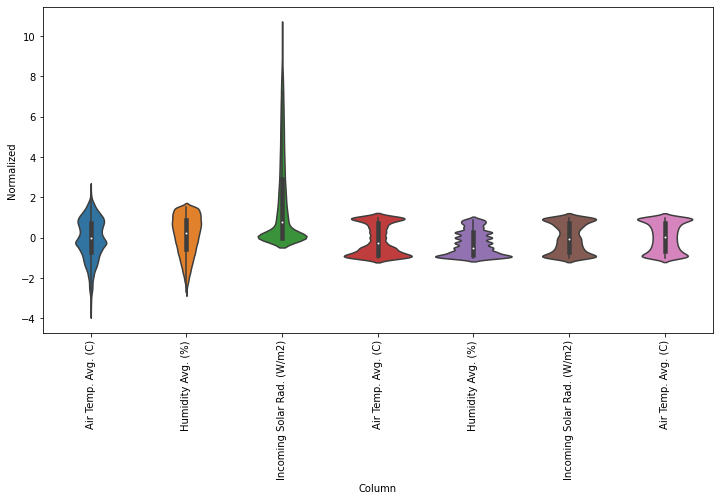

In [18]:
# Sanity check with graphs
train_std = train_df.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=train_std)
_ = ax.set_xticklabels(train_df.keys(), rotation=90)

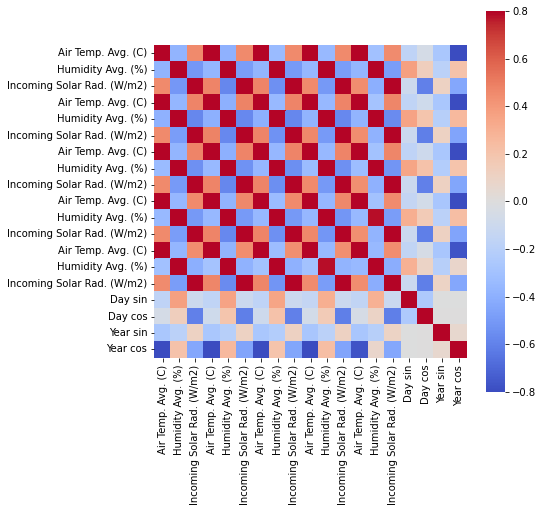

In [19]:
corrmat = df_all#.drop(['TimeOfDay(h)', 'TimeOfDay(m)', 'TimeOfDay(s)', 'UNIXTime', 'MonthOfYear', 'WeekOfYear'], inplace=False, axis=1)
corrmat = corrmat.corr()
f, ax = plt.subplots(figsize=(7,7))
sns.heatmap(corrmat, vmin=-.8, vmax=.8, square=True, cmap = 'coolwarm')
plt.show()

## Data windowing

In [20]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [21]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

### Plot the resulting windows

In [22]:
def plot(self, model=None, plot_col=solar_irr_col, max_subplots=3, test=False):
  '''
  This function plots the window showing inputs vs labels.
  This function plots the prediction vs expected if a model is given, however in this case the label_indices
    must match the number of elements in predictions. Double check when creating the window. length of prediction = length of input_indices
  '''
  if test:
    inputs, labels = next(iter(self.test))
  else:
    inputs, labels = self.example

  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

#### Data Window Test

In [23]:
# Simple test for DATA WINDOW CODE
# Note specifying the label_columns will cause the split_window function to only use the specified column as label
w2 = WindowGenerator(input_width=4, label_width=2, shift=4,
                     label_columns=[solar_irr_col])
w2
# Stack three slices, the length of the total window.
# This takes the number of rows specified by total_windows_size and all the columns
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

# This split each stacked window in example_window into 3 inputs of width=4 and 3 labels of width=2
example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 8, 19)
Inputs shape: (3, 4, 19)
Labels shape: (3, 2, 1)


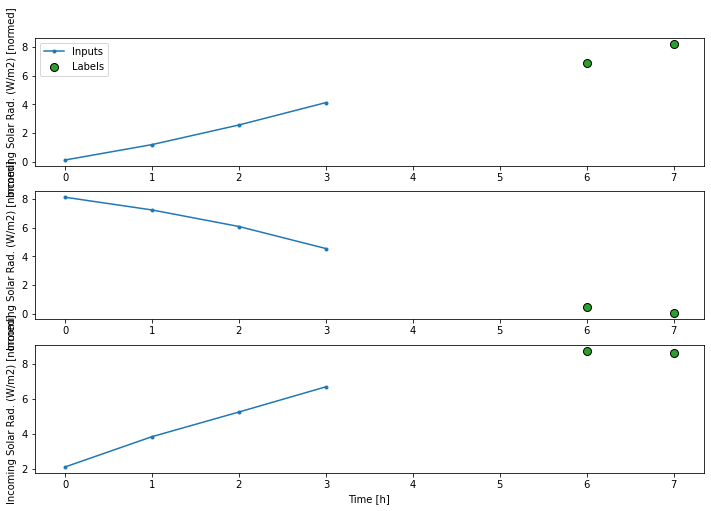

In [24]:
w2.example = example_inputs, example_labels
w2.plot()

### Convert Windows to Dataset Pairs

```make_dataset``` method will take a time series DataFrame and convert it to a ```tf.data.Dataset``` of (input_window, label_window) pairs using the ```preprocessing.timeseries_dataset_from_array``` function. Converting to tf Dataset will allow access to functions like repeat etc. as well.

In [25]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  # This function splits a dataset into a sliding time series window
  # https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=18,
      # The shuffle can be set to False here for the dataset to be in chronological order
      shuffle=True,
      batch_size=700,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [26]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  # Lydia: I added the following line of code
  #   This ensures that everytime WindowGenerator.example is called, we can get a new iteration
  #   of result from the test dataset.
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [27]:
# Some features of dataset
# Each element is an (inputs, label) pair.
w2.train.element_spec

for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (700, 4, 19)
Labels shape (batch, time, features): (700, 2, 1)


# Single Output Model

Create the windows.

Each window takes a day of values which has 18hours after ignoring nightly data.
Also, The label columns should be the first column with the solar irradiance data. Ideally we should rename all the columns when combining the stations' data though.



Lydia: There are a lot of optimization points in the training functions.

## RNN

In [28]:
# Define the training function
MAX_EPOCHS = 30

def compile_and_fit(model, window, patience=2):
  # Stop if the val_loss stops improving with 3 Epochs
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),
                         tf.metrics.MeanAbsolutePercentageError(),
                         tf.metrics.RootMeanSquaredError(),
                         tf.metrics.MeanSquaredError()])
  
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                    validation_data=window.val)

  # history = model.fit(window.train, epochs=MAX_EPOCHS,
  #                     validation_data=window.val,
  #                     callbacks=[early_stopping])


  return history

Lydia: Need note for why RNN is currently the first choice and why LSTM layer is used. Batch number is to be optimized.

In [29]:
# Create the RNN LSTM model
batch = 700

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(units=batch, return_sequences=True),
    # Shape => [batch, time, features]
    # This is the output layer
    tf.keras.layers.Dense(units=1)
])

In [30]:
# Generate the windows for temp prediction
# Width is 24 hours - night time (6 hours) = 18 hours
wide_window = WindowGenerator(
    input_width=18, label_width=18, shift=1,
    label_columns=[solar_irr_col])


# Performance comparison
val_performance = {}
performance = {}


print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

wide_window

Input shape: (700, 18, 19)
Output shape: (700, 18, 1)


Total window size: 19
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Label column name(s): ['Incoming Solar Rad. (W/m2)']

In [31]:
# Compile the model and train
history = compile_and_fit(lstm_model, wide_window)

Epoch 1/30
2/2 [==============================] - 7s 1s/step - loss: 7.1773 - mean_absolute_error: 1.7003 - mean_absolute_percentage_error: 24092848.0000 - root_mean_squared_error: 2.6791 - mean_squared_error: 7.1773 - val_loss: 2.7482 - val_mean_absolute_error: 1.1539 - val_mean_absolute_percentage_error: 55391052.0000 - val_root_mean_squared_error: 1.6578 - val_mean_squared_error: 2.7482
Epoch 2/30
2/2 [==============================] - 4s 590ms/step - loss: 3.6633 - mean_absolute_error: 1.4550 - mean_absolute_percentage_error: 195352240.0000 - root_mean_squared_error: 1.9140 - mean_squared_error: 3.6633 - val_loss: 2.5853 - val_mean_absolute_error: 1.1331 - val_mean_absolute_percentage_error: 77411496.0000 - val_root_mean_squared_error: 1.6079 - val_mean_squared_error: 2.5853
Epoch 3/30
2/2 [==============================] - 4s 595ms/step - loss: 2.2096 - mean_absolute_error: 1.0412 - mean_absolute_percentage_error: 109134232.0000 - root_mean_squared_error: 1.4865 - mean_squared_err

In [32]:
# Evaluate the model with validation data
# IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

1/1 [==============================] - 0s 417ms/step - loss: 0.7754 - mean_absolute_error: 0.5976 - mean_absolute_percentage_error: 65761052.0000 - root_mean_squared_error: 0.8806 - mean_squared_error: 0.7754


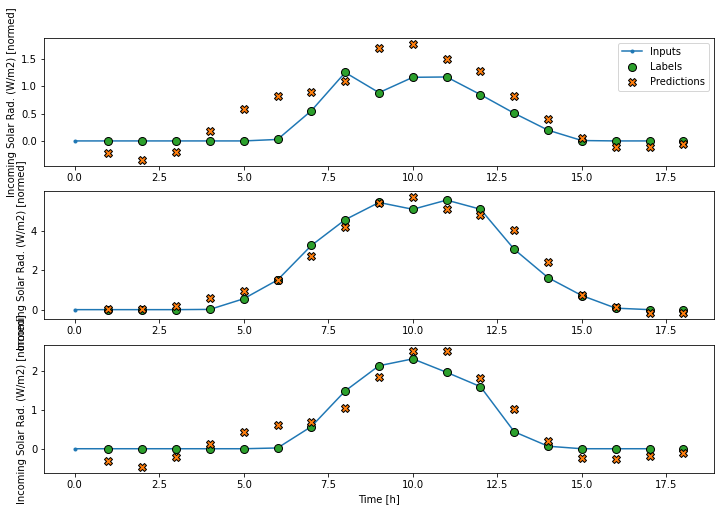

In [33]:
wide_window.plot(lstm_model, test=True)

Check the performance of the model using mean absolute error.

Improvement: Add more performance parameter checks and identify which ones are important.

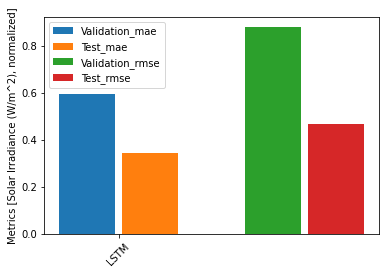

In [34]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

metric_name = 'root_mean_squared_error'
metric_index = lstm_model.metrics_names.index('root_mean_squared_error')
val_rmse = [v[metric_index] for v in val_performance.values()]
test_rmse = [v[metric_index] for v in performance.values()]

plt.ylabel('Metrics [Solar Irradiance (W/m^2), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation_mae')
plt.bar(x + 0.17, test_mae, width, label='Test_mae')
plt.bar(x + 1 - 0.17, val_rmse, width, label='Validation_rmse')
plt.bar(x + 1 + 0.17, test_rmse, width, label='Test_rmse')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()



## Plot for analysis

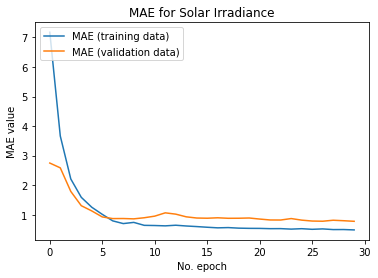

In [35]:
# Overfitting and underfitting analysis
plt.plot(history.history['loss'], label='MAE (training data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE for Solar Irradiance')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

# Post Data Processing

## Save Model and Cleanup

In [36]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 18, 700)           2016000   
                                                                 
 dense (Dense)               (None, 18, 1)             701       
                                                                 
Total params: 2,016,701
Trainable params: 2,016,701
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Change path to desired location
save_path ='new_model'
tf.keras.models.save_model(lstm_model, save_path)

INFO:tensorflow:Assets written to: new_model/assets


INFO:tensorflow:Assets written to: new_model/assets


In [38]:
drive.flush_and_unmount()